In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

df = pd.read_json('../data/database-10-12.json')

#### Füge ein neues Feature hinzu: Themengebiet

In [23]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topic

#### Zähle die Artikel pro Themengebiet

In [24]:
df_topic = df.topic.value_counts().reset_index(name="amount")
df_topic['color'] = "#8ecae6" # BLUE
df_topic['edgecolor'] = "#219ebc" # BLUE

## Erstelle das Diagramm

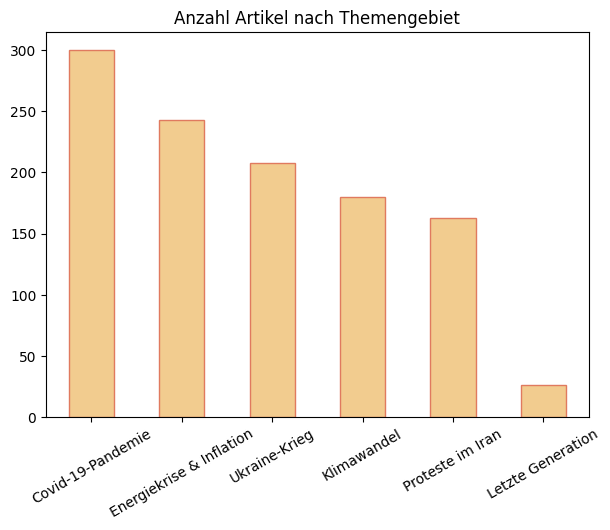

In [25]:
ax = df_topic.plot(kind="bar", x="index", y="amount", figsize=(7,5), legend=False, rot=30, color="#f2cc8f", edgecolor='#e07a5f', title="Anzahl Artikel nach Themengebiet")
ax.axes.get_xaxis().get_label().set_visible(False)

ax.get_figure().savefig('figures/bar-topic.png', bbox_inches="tight")

#### Benenne das Feature `index` zu `topic`

In [26]:
df_topic['topic'] = df_topic['index']

#### Mache Abstufungen in den Farbintensitäten, indem Transparenzwerte angehangen werden

In [27]:
# transparent value from 100% - 10% * n; >34%
transparencies = ["FF", "E6", "CC",  "B3", "80",  "66", "4D"]
used = {"topic": -1}

def highlight_color(row):
    used["topic"] += 1
    row.color += transparencies[used['topic']]
    return row
    
df_topic = df_topic.apply(highlight_color, axis=1)

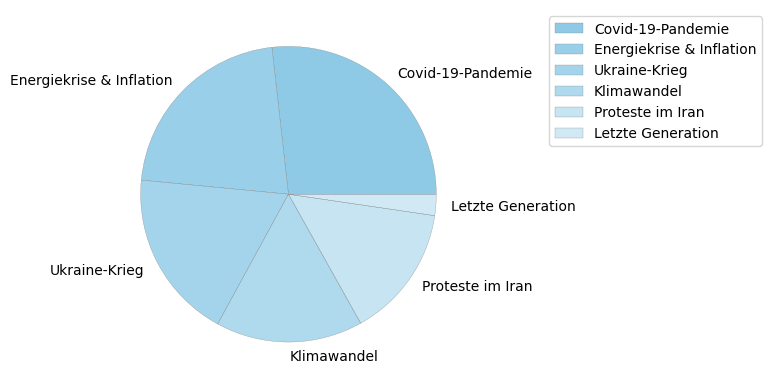

In [28]:
ax = df_topic.plot(kind="pie", y="amount", labels=df_topic.topic, colors=df_topic.color,  wedgeprops={"edgecolor": "grey", 'linewidth': 0.2, 'linestyle': 'solid', 'antialiased': True})

ax.axes.get_yaxis().get_label().set_visible(False)

ax.legend(labels=df_topic.topic, bbox_to_anchor=(1.8, 1.0))

ax.get_figure().savefig('figures/pie-topic.png', bbox_inches="tight")